<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow_datasets as tfds

First, some basic functions.

In [4]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [5]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [6]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

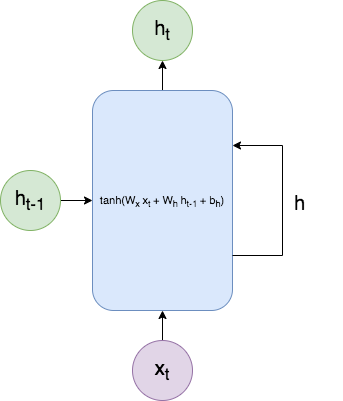

In [7]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [8]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

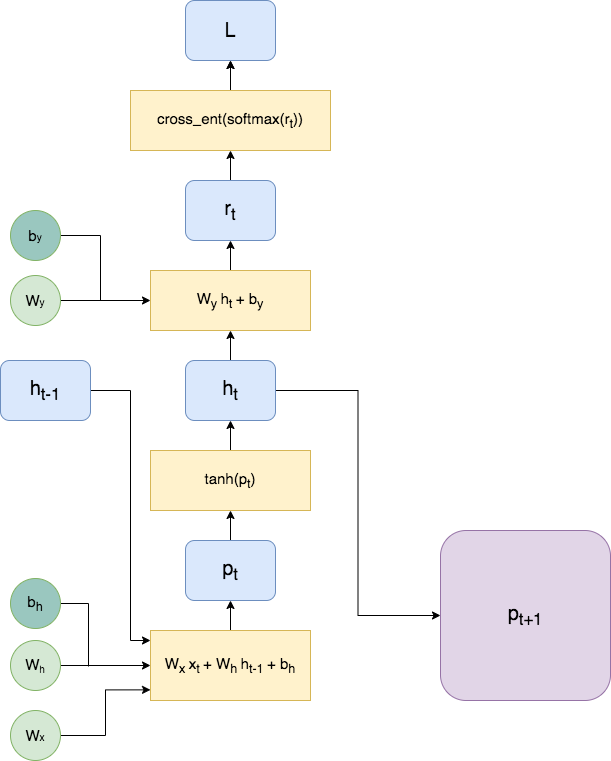

In [9]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [10]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [11]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

2.3607984073364885
0.16584824092460781
0.04812708471639839
0.026364666031947277
0.01744332491300189
0.01268768775462673
0.00980834430634137
0.007921413041365233
0.006610148267592645
0.005655395741432642


In [12]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [26]:
dataset = tfds.load(name='tiny_shakespeare')['train']

In [29]:
def one_hot(k):
    enc = np.zeros((256, 1))
    enc[k, 0] = 1
    return enc

In [30]:
hidden_dim = 64
vocab_size = 256
size = 25
alpha = 1e-2

In [37]:
Wx = np.random.randn(hidden_dim, vocab_size)

Wh = np.random.randn(hidden_dim, hidden_dim)
bh = np.random.randn(hidden_dim, 1)

Wy = np.random.randn(vocab_size, hidden_dim)
by = np.random.randn(vocab_size, 1)

In [39]:
i = 0
losses = []

for record in dataset:
    line = list(record['text'].numpy())

    hzero = np.zeros_like(bh)

    for t in range(0, len(line) - size):
        ts = line[t:t + 25]
        xs = [one_hot(k) for k in ts]
        
        ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
        hs.append(hzero)

        losses.append(loss_fn(ts, ys))

        if i % 500 == 0:
            print(losses[-1])

        dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

        Wy -= alpha * dWy
        by -= alpha * dby

        Wx -= alpha * dWx

        Wh -= alpha * dWh
        bh -= alpha * dbh

        hzero = hs[-2]  # the last h_t will be the next hzero
        i += 1

23.659280442888974
2.4416251031766096
2.963760141452775
2.310929644906607
2.829705450037808
2.3560338113373693
2.683438492091736
2.7825989325547904
2.3630945192168102
2.803415367918679
2.2676530540346365
3.047743619509735
2.0296709051648207
2.4325971171955008
2.4916784079027057
3.005777827641061
3.1489121316503486
2.388648514330727
2.548659259189198
2.649431854782687
2.579483394214664
2.6627757749956777
2.7526635174419063
2.581358709317159
2.654824633850733
3.0876589228878752
2.337940371331274
2.1310504168265045
2.980708119039969
2.5942127496797833
2.4624385241415414
3.1996765909195988
2.083618634000768
2.798033060131551
2.886510293514543
2.7398815514013752
2.9919641022147867
3.0105749573135943
2.6356476559816975
2.6573309871063713
2.417045474668924
2.294921026151218
2.428278622313952
2.609028036476011
2.4110542405705493
2.8652766421681934
2.692796253657495
2.510603823141924
2.8566322376549906
2.767783193099193
2.9938294804821566
2.9267725122440913
2.709799801242959
3.013261839029106
2

KeyboardInterrupt: ignored